### List of dependencies
- networkx
- pandas
- numpy
- matplotlib
- community : you can download it [here](https://bitbucket.org/taynaud/python-louvain/get/6a3696fdce57.zip), then just do  : `sudo python3 setup.py install`
 

In [21]:
import pandas as pd
import numpy as np
import community

#import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import random
import community
%matplotlib inline

In [22]:
df = pd.read_csv("../data/dataset.CSV", sep=";")

In [23]:
df.describe()

,female_id,male_id,date,female_grade,anal,oral,kiss
count,50632.000000,50632.000000,50632.000000,50632.000000,50632.000000,50632.000000,50632.000000
mean,6674.964074,6497.960045,1561.542878,0.742692,0.300758,0.665192,0.629957
std,4599.308794,4544.051880,444.996668,0.604601,0.817198,0.696622,0.696743
min,0.000000,1.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,2813.000000,2422.250000,1238.000000,1.000000,0.000000,1.000000,1.000000
50%,6235.000000,5766.000000,1617.000000,1.000000,1.000000,1.000000,1.000000
75%,10496.000000,10111.250000,1933.000000,1.000000,1.000000,1.000000,1.000000
max,16728.000000,16729.000000,2232.000000,1.000000,1.000000,1.000000,1.000000


### We add an offset to male id in order to not have the same ids in male and female 

In [71]:
offset_male_id = max(df["female_id"]) + 10000
df["male_id"] = df["male_id"] + offset_male_id

### Let's create the graph, we are going to use Multi Graph because we may have multiple edges between the same escort and client

In [72]:
G = nx.MultiGraph()

In [80]:
df_trunc = df[(df.date > 1000) & (df.date < 1800)]

In [82]:
df_trunc.shape

(26182, 7)

In [83]:
list_male_id = df_trunc["male_id"].unique()
list_female_id = df_trunc["female_id"].unique()

### Be sure that there is no intersection between ids

In [84]:
len(set(list_male_id).intersection(set(list_female_id)))

0

In [85]:
print(len(list_male_id), " different clients")

6191  different clients


In [86]:
print(len(list_female_id), " different escort")

4014  different escort


In [87]:
full_node_list = list(list_female_id) + list(list_male_id)

In [88]:
G.add_nodes_from(list_male_id, role="client",status="susceptible")
G.add_nodes_from(list_female_id, role="escort",status="susceptible")

## SI model

In [89]:
proba_transmission = 1
coeff_initial_infected = 0.01
n_initially_infected = int(G.number_of_nodes() * coeff_initial_infected)
initially_infected = random.sample(population=full_node_list, k=n_initially_infected)


value_dict = {}
for node in initially_infected:
    value_dict[node] = "infected"

nx.set_node_attributes(G, "status", value_dict)

In [90]:
def print_stat_inf(G, display=False, freq = False):
    number_of_nodes = G.number_of_nodes()
    number_infected = 0
    
    for node, data in G.nodes_iter(data=True):
        if data["status"] == "infected":
            number_infected += 1
    if display==True:
        print("Number of infected : ",number_infected)
        print(number_infected/number_of_nodes * 100,"% of the population infected.")
        
    if freq == False:
        res = number_infected
        
    elif freq == True:
        res = number_infected / number_of_nodes
    return res

In [91]:
number_infected = print_stat_inf(G, display=True)

Number of infected :  242
1.4465032875074717 % of the population infected.


In [92]:
%%time

date_list = []
infected_list = []

for index, row in df_trunc.iterrows():
    if index % 3000 == 0:
        print("Added ", index, " edges")
    
    #extract data from network
    female_id = row["female_id"]
    male_id = row["male_id"]
    status_male = G.node[male_id]["status"]
    status_female = G.node[female_id]["status"]
    date = row["date"]
    
    #check for transmission with proba_transmission
    if (status_male=="infected") and (status_female=="susceptible"):
        toss = random.uniform(0, 1)
        if toss < proba_transmission:
            G.node[female_id]["status"] = "infected"
    
    elif (status_female=="infected") and (status_male=="susceptible"):
        toss = random.uniform(0, 1)
        if toss < proba_transmission:
            G.node[male_id]["status"] = "infected"
    
    number_infected = print_stat_inf(G, freq = True)
    date_list.append(date)
    infected_list.append(number_infected)
    
    
    G.add_edge(row["female_id"], row["male_id"])
    


Added  9000  edges
Added  12000  edges
Added  15000  edges
Added  18000  edges
Added  21000  edges
Added  24000  edges
Added  27000  edges
Added  30000  edges
CPU times: user 1min 27s, sys: 327 ms, total: 1min 27s
Wall time: 1min 27s


In [93]:
df_infection = pd.DataFrame()
df_infection["date"] = date_list
df_infection["nb_infecte"] = infected_list

In [94]:
groupby_date = df_infection.groupby("date").max()

In [95]:
groupby_date

,nb_infecte
date,
1001,0.014465
1002,0.014465
1003,0.014465
1004,0.014465
1005,0.014465
1006,0.014465
1007,0.014465
1008,0.014465
1009,0.014525


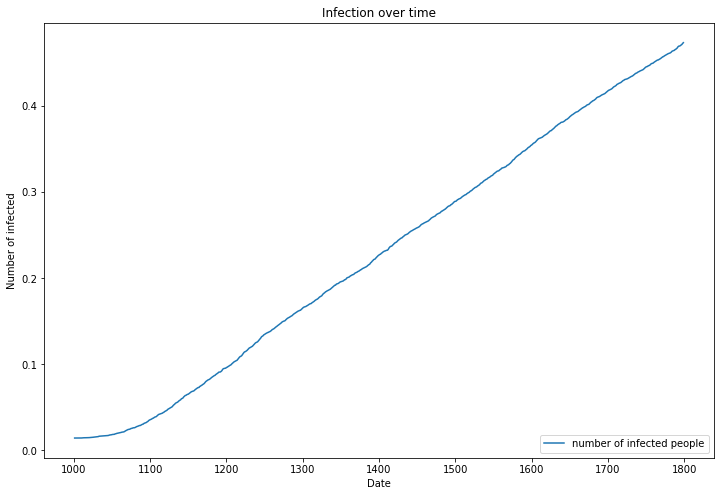

In [96]:
plt.figure(figsize=(12,8))
plt.title("Infection over time")
plt.plot(groupby_date.index, groupby_date["nb_infecte"], label="number of infected people")
plt.ylabel("Number of infected")
plt.xlabel("Date")
#plt.axhline(y=G.number_of_nodes(), xmin=0, xmax=3000, linewidth=2, linestyle="dashed",color = 'r', label="Total population")
plt.legend(loc=4)

## SIR model

In [ ]:
G = nx.MultiGraph()